In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from itertools import combinations

### Обработка датасета

In [ ]:
DATASET_PATH = 'penguins.csv'
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'penguins.csv'

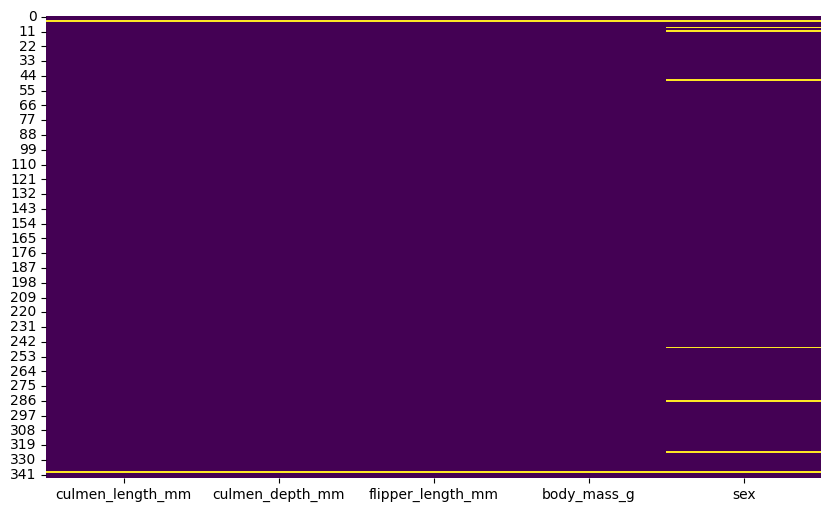

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [ ]:
df_cleaned = df.dropna(how='all')

known_sex = df_cleaned['sex'].dropna()
sex_distribution = known_sex.value_counts(normalize=True)

missing_mask = df_cleaned['sex'].isna()
random_sex = np.random.choice(sex_distribution.index,
                             size=missing_mask.sum(),
                             p=sex_distribution.values)
df_cleaned.loc[missing_mask, 'sex'] = random_sex
df = df_cleaned

In [ ]:
def analyze_outliers_percentage(df, numeric_columns):
    outlier_analysis = {}

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100

        outlier_analysis[col] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'bounds': [lower_bound, upper_bound]
        }

    return outlier_analysis

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

outlier_report = analyze_outliers_percentage(df, numeric_cols)

print("Column outlier anaysis:")
print(f"{'Column':<30} {'Outlier':<10} {'%':<8}")

for col, stats in outlier_report.items():
    print(f"{col:<30} {stats['count']:<10} {stats['percentage']:<7.1f}")

Column outlier anaysis:
Column                         Outlier    %       
culmen_length_mm               0          0.0    
culmen_depth_mm                0          0.0    
flipper_length_mm              2          0.6    
body_mass_g                    0          0.0    


In [ ]:
df['flipper_length_mm'] = winsorize(df['flipper_length_mm'], limits = [0.01, 0.01]).data

In [ ]:
df['sex'] = df['sex'].map({'FEMALE': 0, 'MALE': 1})

In [ ]:
df.head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.884499,0.785449,-1.413119,-0.564142,1.0
1,-0.811126,0.126188,-1.059529,-0.501703,0.0
2,-0.664380,0.430462,-0.423067,-1.188532,0.0
4,-1.324737,1.089724,-0.564503,-0.938776,0.0
5,-0.847812,1.748985,-0.776657,-0.689020,1.0


In [ ]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
df.to_csv("penguins_processed.csv", index = False)

NameError: name 'df' is not defined

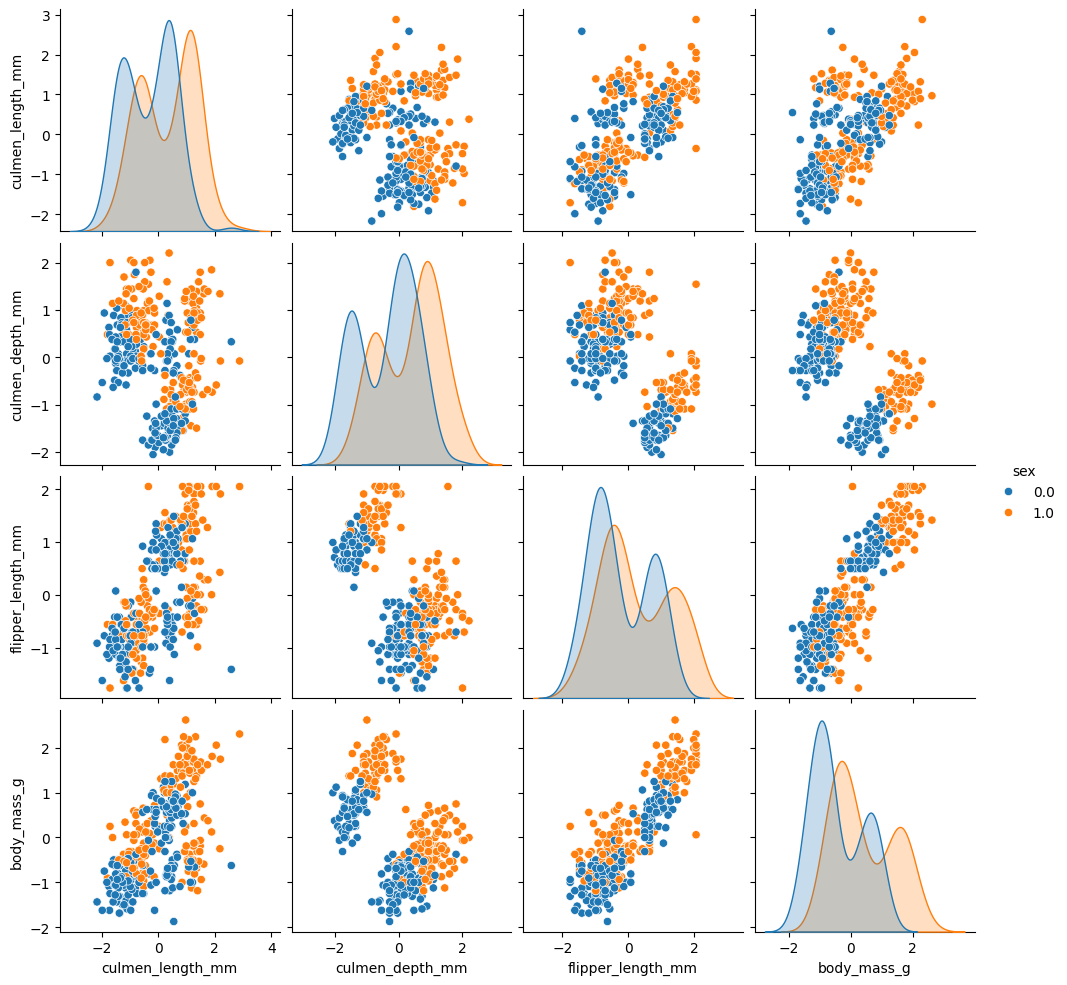

In [ ]:
sns.pairplot(df, hue='sex')

In [2]:
DATASET_PATH = 'penguins_processed.csv'
df = pd.read_csv(DATAS
                 ET_PATH, sep=',')
df.head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.884499,0.785449,-1.413119,-0.564142,1.0
1,-0.811126,0.126188,-1.059529,-0.501703,0.0
2,-0.664380,0.430462,-0.423067,-1.188532,0.0
3,-1.324737,1.089724,-0.564503,-0.938776,0.0
4,-0.847812,1.748985,-0.776657,-0.689020,1.0


### K-средних

In [3]:
class KMeans:
    def __init__(self, k=3, max_iters=1000, tol=1e-5):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        X = np.array(X)
        n_samples, n_features = X.shape
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            distances = self.calc_distances(X, self.centroids)
            self.labels = np.argmin(distances, axis=1)
            new_centroids = np.zeros((self.k, n_features))
            for cluster_idx in range(self.k):
                cluster_points = X[self.labels == cluster_idx]
                if len(cluster_points) > 0:
                    new_centroids[cluster_idx] = cluster_points.mean(axis=0)
                else:
                    new_centroids[cluster_idx] = self.centroids[cluster_idx]

            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                print(f"Сходимость достигнута на итерации {i}")
                break

            self.centroids = new_centroids

    def calc_distances(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return distances

Сходимость достигнута на итерации 5


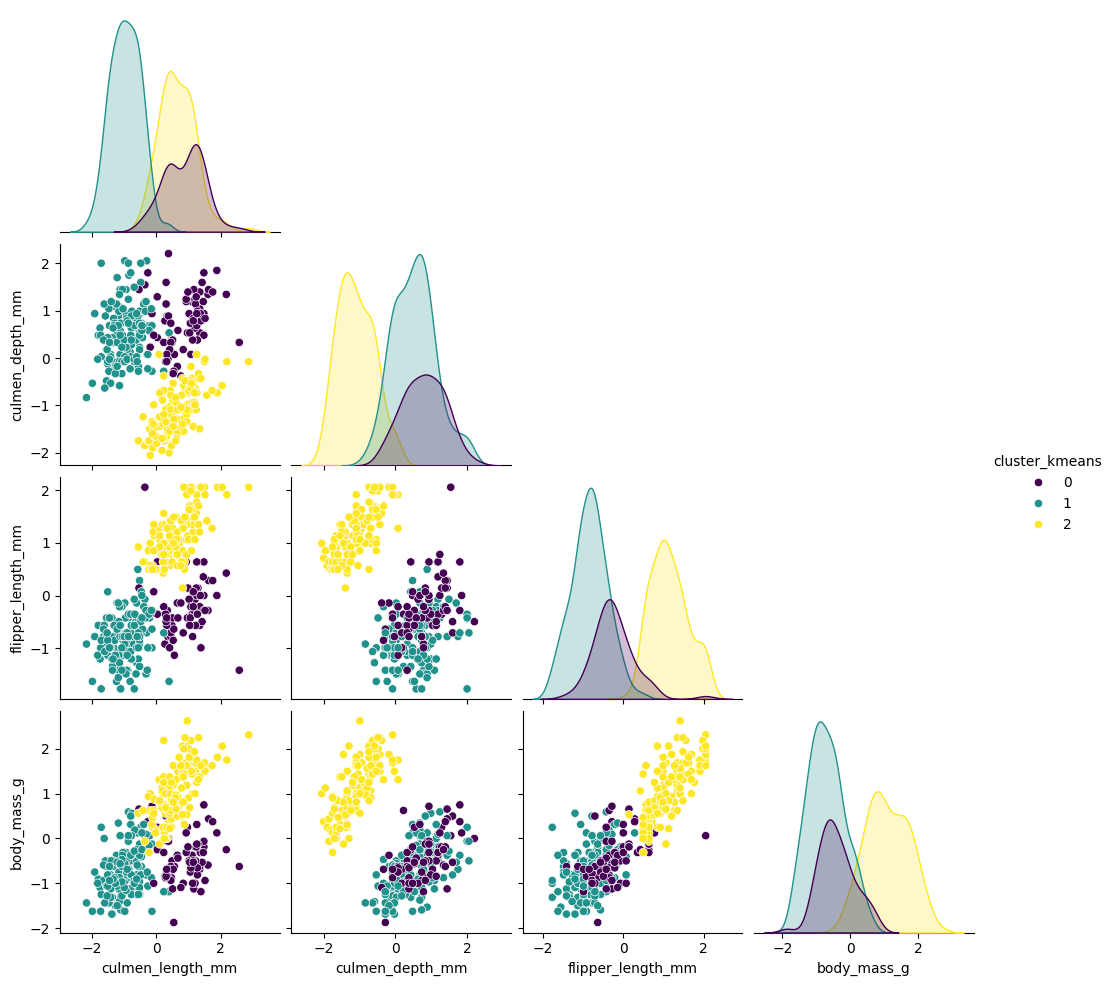

In [4]:
feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[feature_cols].values

kmeans = KMeans(k=3, max_iters=1000, tol = 1e-10)
kmeans.fit(X)
df['cluster_kmeans'] = kmeans.labels
sns.pairplot(
    df,
    hue='cluster_kmeans',
    palette='viridis',
    vars=feature_cols,
    diag_kind='kde',
    corner=True
)
plt.show()

#### С-средних

In [5]:
class FuzzyCMeans:
    def __init__(self, n_clusters=3, m=2, max_iters=100, tol=1e-4):
        self.c = n_clusters
        self.m = m
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.u = None

    def fit(self, X):
        X = np.array(X)
        n_samples, n_features = X.shape
        np.random.seed(42)
        self.u = np.random.rand(n_samples, self.c)
        self.u = self.u / self.u.sum(axis=1, keepdims=True)

        for iteration in range(self.max_iters):
            u_old = self.u.copy()
            u_m = self.u ** self.m
            numerator = np.dot(u_m.T, X)
            denominator = u_m.sum(axis=0)
            self.centroids = numerator / denominator[:, np.newaxis]
            distances = self._calc_distances(X, self.centroids)
            distances = np.fmax(distances, 1e-10)
            power = 2 / (self.m - 1)
            inv_distances = 1.0 / (distances ** power)
            self.u = inv_distances / inv_distances.sum(axis=1, keepdims=True)
            if np.linalg.norm(self.u - u_old) < self.tol:
                print(f"FCM сошелся на итерации {iteration}")
                break

    def _calc_distances(self, X, centroids):
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def predict(self):
        return np.argmax(self.u, axis=1)

    def predict_proba(self):
        return self.u


FCM сошелся на итерации 28


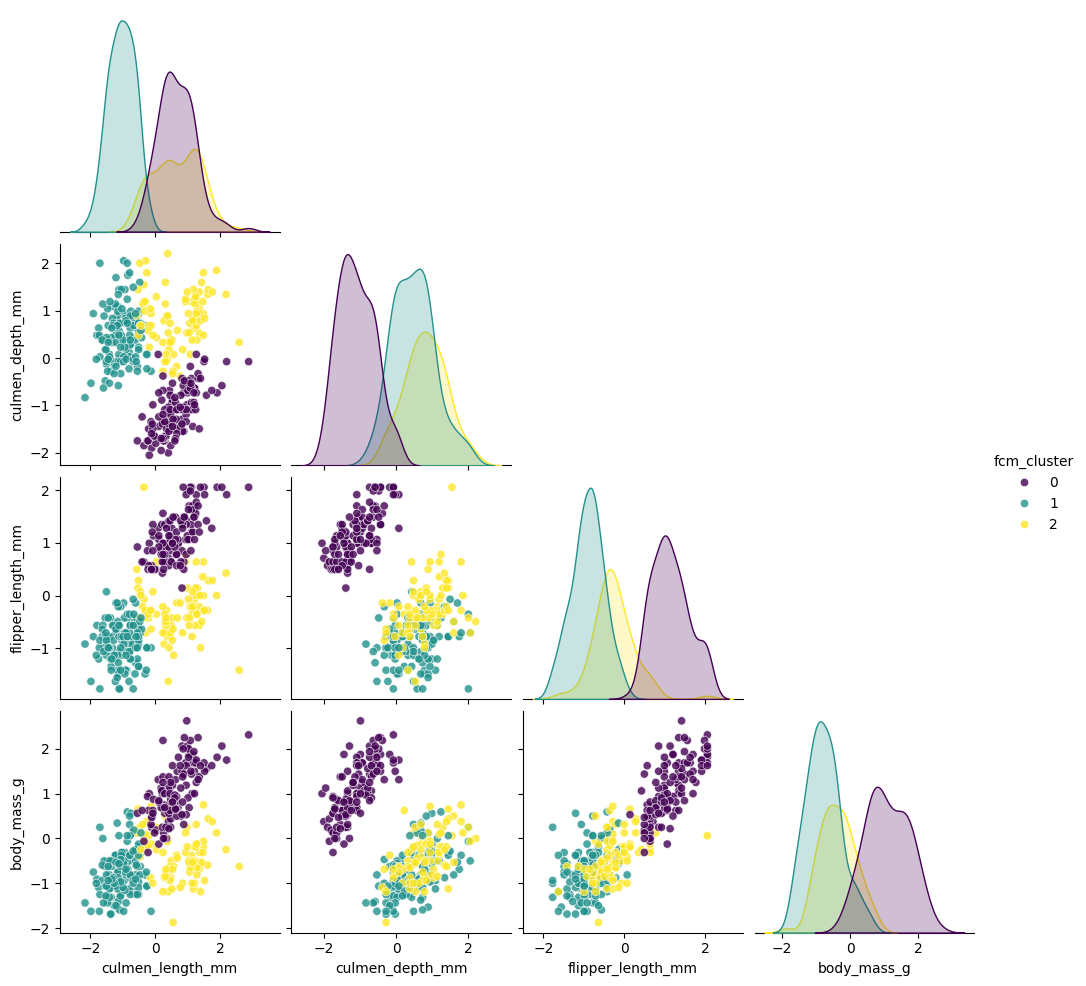

In [6]:
feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[feature_cols].values

fcm = FuzzyCMeans(n_clusters=3, m=2.0, max_iters=100)
fcm.fit(X)

hard_labels = fcm.predict()
soft_labels = fcm.predict_proba()
df['fcm_cluster'] = hard_labels
df['confidence'] = np.max(soft_labels, axis=1)
sns.pairplot(
    df,
    hue='fcm_cluster',
    palette='viridis',
    vars=feature_cols,
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.8}
)
plt.show()

### Иерархическая кластеризация

In [7]:
class AgglomerativeClustering:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.labels = None
        self.history = []

    def fit(self, X):
        X = np.array(X)
        n_samples, n_features = X.shape
        self.labels = np.arange(n_samples)

        current_n_clusters = n_samples
        while current_n_clusters > self.n_clusters:
            unique_labels = np.unique(self.labels)
            centroids = []
            for label in unique_labels:
                points = X[self.labels == label]
                centroids.append(points.mean(axis=0))

            centroids = np.array(centroids)
            dists = self.calc_pairwise_distances(centroids)
            np.fill_diagonal(dists, np.inf)
            min_idx = np.unravel_index(np.argmin(dists), dists.shape)
            cluster_idx1, cluster_idx2 = min_idx
            label_to_keep = unique_labels[cluster_idx1]
            label_to_merge = unique_labels[cluster_idx2]
            self.labels[self.labels == label_to_merge] = label_to_keep

            current_n_clusters -= 1
        _, new_labels = np.unique(self.labels, return_inverse=True)
        self.labels = new_labels

    def calc_pairwise_distances(self, centroids):
        return np.linalg.norm(centroids[:, np.newaxis] - centroids, axis=2)

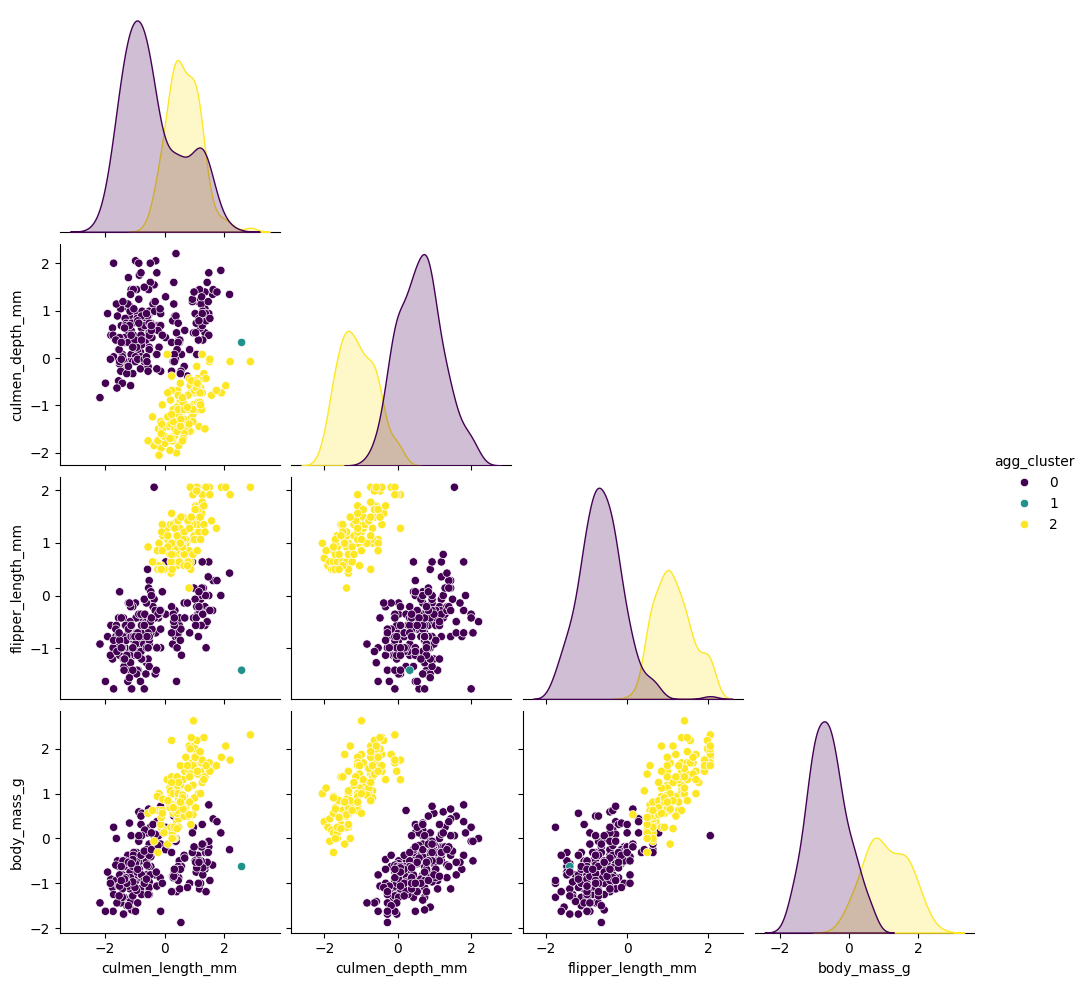

In [8]:
feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[feature_cols].values
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_clustering.fit(X)
df['agg_cluster'] = agg_clustering.labels
sns.pairplot(
    df,
    hue='agg_cluster',
    palette='viridis',
    vars=feature_cols,
    diag_kind='kde',
    corner=True
)
plt.show()

/tmp/ipython-input-770782806.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


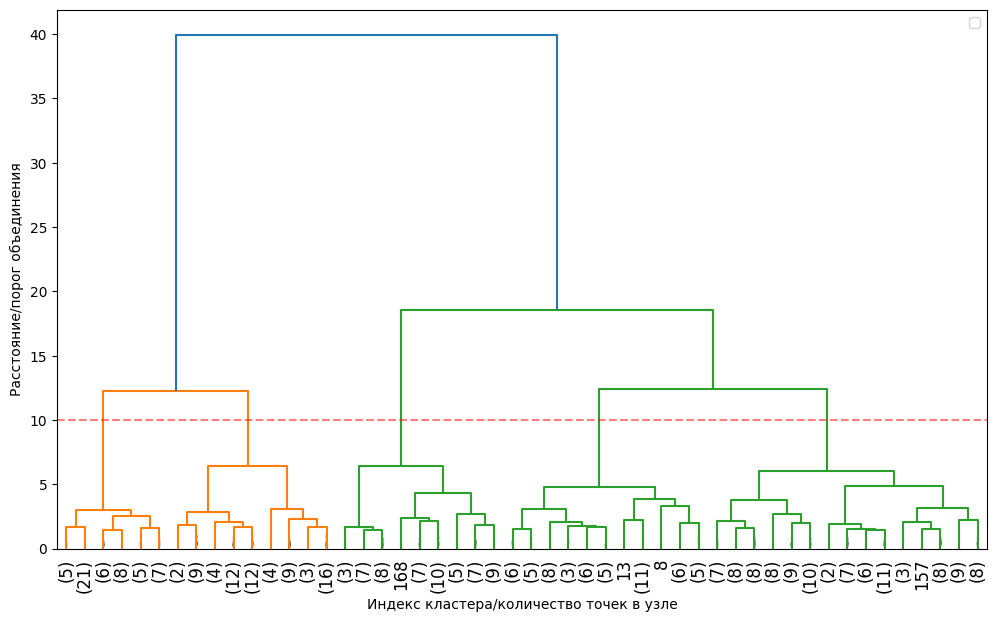

In [9]:
plt.figure(figsize=(12, 7))
Z = linkage(X, method='ward')

dendrogram(
    Z,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)

plt.xlabel("Индекс кластера/количество точек в узле")
plt.ylabel("Расстояние/порог объединения")
plt.axhline(y=10, c='r', ls='--', alpha=0.5)
plt.legend()
plt.show()

### DBSCAN

In [10]:
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None

    def fit(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        self.labels = np.full(n_samples, None)

        cluster_id = 0

        for i in range(n_samples):
            if self.labels[i] is not None:
                continue
            neighbors = self._region_query(X, i)
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1
            else:
                self.labels[i] = cluster_id
                self._expand_cluster(X, neighbors, cluster_id)
                cluster_id += 1
        self.labels = self.labels.astype(int)

    def _expand_cluster(self, X, neighbors, cluster_id):
        i = 0
        while i < len(neighbors):
            point_idx = neighbors[i]
            if self.labels[point_idx] == -1:
                self.labels[point_idx] = cluster_id
            elif self.labels[point_idx] is None:
                self.labels[point_idx] = cluster_id
                new_neighbors = self._region_query(X, point_idx)

                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))

            i += 1

    def _region_query(self, X, point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.eps)[0]

Предполагаемое число кластеров: 3
Количество шумовых выбросов: 46


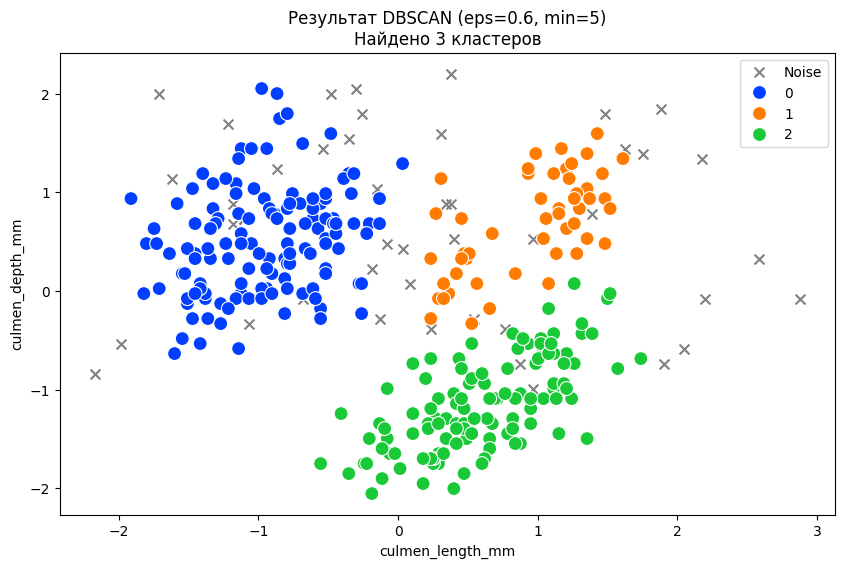

In [11]:
feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[feature_cols].values

dbscan = DBSCAN(eps=0.55, min_samples=5)
dbscan.fit(X)

df['dbscan_cluster'] = dbscan.labels

n_clusters_ = len(set(dbscan.labels)) - (1 if -1 in dbscan.labels else 0)
n_noise_ = list(dbscan.labels).count(-1)

print(f'Предполагаемое число кластеров: {n_clusters_}')
print(f'Количество шумовых выбросов: {n_noise_}')

plt.figure(figsize=(10, 6))

noise_data = df[df['dbscan_cluster'] == -1]
plt.scatter(noise_data['culmen_length_mm'], noise_data['culmen_depth_mm'],
            c='gray', marker='x', s=50, label='Noise')

cluster_data = df[df['dbscan_cluster'] != -1]
sns.scatterplot(data=cluster_data, x='culmen_length_mm', y='culmen_depth_mm',
                hue='dbscan_cluster', palette='bright', s=100)

plt.title(f'Результат DBSCAN (eps=0.6, min=5)\nНайдено {n_clusters_} кластеров')
plt.legend()
plt.show()

### Итоги

In [12]:
class ClusterEvaluator:
    @staticmethod
    def calculate_metrics(X, labels, centroids=None):
        unique_labels = np.unique(labels)
        valid_labels = [l for l in unique_labels if l != -1]

        if len(valid_labels) < 2:
            return None

        computed_centroids = []
        intra_dists = []
        wcss = 0

        for label in valid_labels:
            cluster_points = X[labels == label]
            if centroids is not None and len(centroids) == len(valid_labels):
                center = centroids[label]
            else:
                center = cluster_points.mean(axis=0)

            computed_centroids.append(center)

            dists = np.linalg.norm(cluster_points - center, axis=1)
            wcss += np.sum(dists ** 2)
            intra_dists.append(np.mean(dists))

        computed_centroids = np.array(computed_centroids)

        inter_dists = []
        for c1, c2 in combinations(computed_centroids, 2):
            dist = np.linalg.norm(c1 - c2)
            inter_dists.append(dist)

        return {
            'Num_Clusters': len(valid_labels),
            'WCSS (Total Intra)': round(wcss, 2),
            'Avg Intra-Dist': round(np.mean(intra_dists), 3),
            'Total Inter-Dist': round(np.sum(inter_dists), 2),
            'Avg Inter-Dist': round(np.mean(inter_dists), 3),
            'Ratio (Inter/Intra)': round(np.mean(inter_dists) / np.mean(intra_dists), 3)
        }


In [13]:
feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[feature_cols].values

results_kmeans = []
print("Оцениваем K-Means...")

for k in range(2, 7):
    model = KMeans(k=k, max_iters=300)
    model.fit(X)

    metrics = ClusterEvaluator.calculate_metrics(X, model.labels, model.centroids)
    results_kmeans.append(metrics)

df_kmeans = pd.DataFrame(results_kmeans).set_index('Num_Clusters')

results_fcm = []
print("Оцениваем Fuzzy C-Means...")

for k in range(2, 7):
    model = FuzzyCMeans(n_clusters=k, m=2, max_iters=100)
    model.fit(X)
    hard_labels = model.predict()
    metrics = ClusterEvaluator.calculate_metrics(X, hard_labels, model.centroids)
    results_fcm.append(metrics)

df_fcm = pd.DataFrame(results_fcm).set_index('Num_Clusters')

results_ward = []
print("Оцениваем Ward Clustering...")

for k in range(2, 7):
    model = AgglomerativeClustering(n_clusters=k)
    model.fit(X)

    metrics = ClusterEvaluator.calculate_metrics(X, model.labels)
    results_ward.append(metrics)

df_ward = pd.DataFrame(results_ward).set_index('Num_Clusters')

results_dbscan = []
print("Оцениваем DBSCAN...")

eps_values = [0.5, 0.55, 0.6]

for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=5)
    model.fit(X)

    metrics = ClusterEvaluator.calculate_metrics(X, model.labels)
    if metrics:
        metrics['Eps_Param'] = eps
        metrics['Noise_Points'] = list(model.labels).count(-1)
        results_dbscan.append(metrics)

df_dbscan = pd.DataFrame(results_dbscan)
if not df_dbscan.empty:
    df_dbscan = df_dbscan.set_index('Eps_Param')

from IPython.display import display

print("\n--- 1. Результаты K-Means ---")
display(df_kmeans)

print("\n--- 2. Результаты Fuzzy C-Means ---")
display(df_fcm)

print("\n--- 3. Результаты Ward (Hierarchy) ---")
display(df_ward)

print("\n--- 4. Результаты DBSCAN ---")
display(df_dbscan)

Оцениваем K-Means...
Сходимость достигнута на итерации 2
Сходимость достигнута на итерации 7
Сходимость достигнута на итерации 9
Сходимость достигнута на итерации 10
Сходимость достигнута на итерации 19
Оцениваем Fuzzy C-Means...
FCM сошелся на итерации 12
FCM сошелся на итерации 28
FCM сошелся на итерации 33
FCM сошелся на итерации 42
FCM сошелся на итерации 33
Оцениваем Ward Clustering...
Оцениваем DBSCAN...

--- 1. Результаты K-Means ---


,WCSS (Total Intra),Avg Intra-Dist,Total Inter-Dist,Avg Inter-Dist,Ratio (Inter/Intra)
Num_Clusters,,,,,
2,571.68,1.142,3.18,3.180,2.784
3,492.42,0.892,8.16,2.721,3.049
4,317.81,0.875,15.31,2.552,2.916
5,289.86,0.797,23.80,2.380,2.987
6,221.78,0.711,40.75,2.717,3.819



--- 2. Результаты Fuzzy C-Means ---


,WCSS (Total Intra),Avg Intra-Dist,Total Inter-Dist,Avg Inter-Dist,Ratio (Inter/Intra)
Num_Clusters,,,,,
2,584.82,1.171,3.11,3.112,2.658
3,384.19,0.991,8.17,2.722,2.748
4,306.15,0.835,16.58,2.763,3.307
5,246.66,0.776,27.18,2.718,3.504
6,231.17,0.712,39.54,2.636,3.699



--- 3. Результаты Ward (Hierarchy) ---


,WCSS (Total Intra),Avg Intra-Dist,Total Inter-Dist,Avg Inter-Dist,Ratio (Inter/Intra)
Num_Clusters,,,,,
2,571.68,1.142,3.18,3.180,2.784
3,562.25,0.758,10.17,3.388,4.469
4,553.65,0.567,21.01,3.501,6.178
5,541.98,0.533,37.41,3.741,7.021
6,536.27,0.443,56.80,3.787,8.543



--- 4. Результаты DBSCAN ---


,Num_Clusters,WCSS (Total Intra),Avg Intra-Dist,Total Inter-Dist,Avg Inter-Dist,Ratio (Inter/Intra),Noise_Points
Eps_Param,,,,,,,
0.50,4,222.57,0.681,14.28,2.379,3.492,68
0.55,3,266.81,0.868,8.28,2.759,3.178,46
0.60,2,437.96,1.065,3.18,3.180,2.985,32
